In [1]:
MALE = 'male'
FEMALE = 'female'
UNKNOWN = 'unknown'
BOTH = 'both'

MALE_WORDS = set([
        'guy','spokesman','chairman',"men's",'men','him',"he's",'his',
        'boy','boyfriend','boyfriends','boys','brother','brothers','dad',
        'dads','dude','father','fathers','fiance','gentleman','gentlemen',
        'god','grandfather','grandpa','grandson','groom','he','himself',
        'husband','husbands','king','male','man','mr','nephew','nephews',
        'priest','prince','son','sons','uncle','uncles','waiter','widower',
        'widowers'
])

FEMALE_WORDS = set([
        'heroine','spokeswoman','chairwoman',"women's",'actress','women',
        "she's",'her','aunt','aunts','bride','daughter','daughters','female',
        'fiancee','girl','girlfriend','girlfriends','girls','goddess',
        'granddaughter','grandma','grandmother','herself','ladies','lady',
        'lady','mom','moms','mother','mothers','mrs','ms','niece','nieces',
        'priestess','princess','queens','she','sister','sisters','waitress',
        'widow','widows','wife','wives','woman'
])

In [2]:
def genderize(words):
    
    mwlen = len(MALE_WORDS.intersection(words))
    fwlen = len(FEMALE_WORDS.intersection(words))
    
    if mwlen > 0 and fwlen == 0:
        return MALE
    elif mwlen == 0 and fwlen > 0:
        return FEMALE
    elif mwlen > 0 and fwlen > 0:
        return BOTH
    else:
        return UNKNOWN

In [3]:
from collections import Counter

def count_gender(sentences):
    
    sents = Counter()
    words = Counter()
    
    for sentence in sentences:
        gender = genderize(sentence)
        sents[gender] += 1
        words[gender] += len(sentence)
        
    return sents, words

In [4]:
import nltk

def parse_gender(text):
    
    sentences = [
        [word.lower() for word in nltk.word_tokenize(sentence)]
        for sentence in nltk.sent_tokenize(text)
    ]
    
    sents, words = count_gender(sentences)
    total = sum(words.values())
    
    for gender, count in words.items():
        pcent = (count / total) * 100
        nsents = sents[gender]
        
        print(
        '{}% {} ({} sentences)'.format(pcent, gender, nsents)
        )

In [5]:
# New York Times entitled “Rehearse, Ice Feet, Repeat: The Life of a New York City Ballet Corps Dancer”

article = ("With apologies to James Brown, the hardest working people in show business may well be ballet dancers. And at New York City Ballet, none work harder than the dancers in its lowest rank, the corps de ballet. During the first week of the company’s winter season, Claire Kretzschmar, 24, a rising corps member, danced in all seven performances, appearing in five ballets, sometimes changing costumes at intermission to dance two roles in a night.     But her work onstage did not even begin to capture the stamina required to be in the corps. Spending a week shadowing Ms. Kretzschmar was exhausting — she gave new meaning to the idea of being on your feet all day. Twelve-hour days at the David H. Koch Theater, the company’s Lincoln Center home, were hardly unusual: Company class each morning was followed by back-to-back-to-back rehearsals, with occasional breaks for costume fittings or physical therapy, and then by the hair-makeup-costume-dance routine of daily performances. This weekend will be even more frenetic. Ms. Kretzschmar will appear in seven ballets from Friday evening to Sunday afternoon, when she faces a new test: taking on the title role of the Sleepwalker in George Balanchine’s eerie, proto-goth ballet “La Sonnambula.” Balanchine, one of ballet’s most important choreographers, was a founder of City Ballet, and remains its guiding spirit more than three decades after his death. Being in City Ballet’s corps is not like being a member of a chorus line, or a backup singer. The company promotes almost all of its stars, the principal dancers, from within. So while the corps is expected to be able to move in startling unison, like a school of fish, and to assemble in straight lines and keep all rippling swan arms parallel, its 54 members are also competing for bigger roles and promotions. “There is an element of competition, and people get different opportunities, but everybody just wants to do their best onstage, and everyone wants each other to just do their best onstage,” Ms. Kretzschmar said during a break between rehearsals last week. “We have all experienced so many extreme highs and lows that it’s almost that you have to bond with this group of people. Here are scenes from one week in the busy life of a corps member.")


In [6]:
parse_gender(article)

73.57630979498862% unknown (11 sentences)
9.79498861047836% female (2 sentences)
16.62870159453303% both (1 sentences)


In [7]:
from nltk.corpus.reader.plaintext import CategorizedPlaintextCorpusReader

DOC_PATTERN = r'(?!\.)[\w)\s]+/[\w\s\d\-]+\.txt'
CAT_PATTERN = r'([\w)\s]+)/.*'

# corpus = CategorizedPlaintextCorpusReader(
#     '/path/to/corpus/root', DOC_PATTERN, cat_pattern=CAT_PATTERN)

In [8]:
from nltk.corpus.reader.api import CorpusReader
from nltk.corpus.reader.api import CategorizedCorpusReader
import codecs

CAT_PATTERN =  r'([\w)\s]+)/.*'
DOC_PATTERN = r'(?!\.)[\w)\s]+/[\w\s\d\-]+\.txt'

TAGS = ['h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'p', 'li']

class HTMLCorpusReader(CategorizedCorpusReader, CorpusReader):
    # corpus reader for raw html docs to enable preprocessing
    
    def __init__(self, root, fileids=DOC_PATTERN, encoding='utf8',
                tags=TAGS, **kwargs):
        
        # add default category pattern if not passed into the class
        if not any(key.startswith('cat_') for key in kwargs.keys()):
            kwargs['cat_pattern'] = CAT_PATTERN
            
        # initialize NLTK corpus reader objects
        CategorizedCorpusReader.__init__(self, kwargs)
        CorpusReader.__init__(self, root, fileids, encoding)
        
        # save tags specifically want to extract
        self.tags = tags
        
    
    def resolve(self, fileids, categories):
        """
        returns list of fields or categories depending on what is passed
        to each internal corpus reader function. implemented similarly
        to NLTK CategorizedPlaintextCorpusReader
        """
        
        if fileids is not None and categories is not None:
            raise ValueError('specify fileids or categories, not both')
            
        if categories is not None:
            return self.fileids(categories)
        return fileids
    
    
    def docs(self, fileids=None, categories=None):
        """
        returns complete text of HTML doc, closing doc after done
        reading it and yielding in memory safe fashion
        """
        
        # resolve fileids and categories
        fileids = self.resolve(fileids, categories)
        
        # create generator, loading one doc into memory at a time
        for path, encoding in self.abspaths(fileids, include_encoding=True):
            with codecs.open(path, 'r', encoding=encoding) as f:
                yield f.read()
                
                
    def sizes(self, fileids=None, categories=None):
        """
        returns list of tuples, fileid and size on disk of file.
        this function is used to detect oddly large files in corpus
        """
        
        fileids = self.resolve(fileids, categories)
        
        for path in self.abspaths(fileids):
            yield os.path.getsize(path)

In [9]:
import sqlite3

class SqliteCorpusReader(object):
    
    def __init__(self, path):
        self._cur = sqlite3.connect(path).cursor()
        
    def ids(self):
        """
        returns review ids, which enable joins to other metadata
        """
        self._cur.execute('SELECT reviewid FROM content')
        for idx in iter(self._cur.fetchone, None):
            yield idx
            
    def scores(self):
        """
        returns review score to be used as the target for
        later supervised learning problems
        """
        self._cur.execute('SELECT score FROM reviews')
        for score in iter(self._cur.fetchone, None):
            yield score
            
    def texts(self):
        """
        returns full review texts, to be preprocessed and
        vectorized for supervised learning
        """
        self._cur.execute('SELECT content FROM content')
        for text in iter(self._cur.fetchone, None):
            yield text
        

In [12]:
from readability.readability import Unparseable
from readability.readability import Document as Paper

def html(self, fileids=None, categories=None):
    """
    returns HTML content of eachd ocument, cleaning it using
    the readability-lxml library
    """
    for doc in self.docs(fileids, categories):
        try:
            yield Paper(doc).summary()
        except Unparseable as e:
            print('Could not parse HTML: {}'.format(e))
            continue
    

In [13]:
import bs4

TAGS = ['h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'p', 'li']

def paras(self, fileids=None, categories=None):
    """
    uses BeautifulSoup to parse paragraphs from HTML.
    """
    for html in self.html(fileids, categories):
        soup = bs4.BeautifulSoup(html, 'lxml')
        for element in soup.find_all(tags):
            yield element.text
        # destroys tree when done with each file
        soup.decompose

In [14]:
from nltk import sent_tokenize
from nltk import wordpunct_tokenize
from nltk import pos_tag, sent_tokenize

def sents(self, fileids=None, categories=None):
    """
    use built in sentence tokenizer to extract sentences. this method uses
    BS to parse HTML
    """
    for paragraph in self.paras(fileids, categories):
        for sentence in sent_tokenize(paragraph):
            yield sentence
            
def words(self, fileids=None, categories=None):
    for sentence in self.sents(fileids, categories):
        for token in wordpunct_tokenize(sentence):
            yield token
            
def tokenize(self, fileids=None, categories=None):
    """
    segments, tokenizes and tags a document in corpus
    """
    for paragraph in self.paras(fileids=fileids):
        yield [
            pos_tag(wordpunct_tokenize(sent))
            for sent in sent_tokenize(paragraph)
        ]

In [15]:
import time

def describe(self, fileids=None, categories=None):
    """
    performs single pass of corpus and returns dict with variety
    of metrics concerning state of corpus
    """
    started = time.time()
    
    # structure to perform counting
    counts = nltk.FreqDist()
    tokens = nltk.FreqDist()
    
    # perform single pass over paragraphs, tokenize and count
    for para in self.paras(fileids, categories):
        counts['paras'] += 1
        
        for sent in para:
            counts['sents'] += 1
            
            for word, tag in sent:
                counts['words'] += 1
                tokens[word] += 1
                
    # computer number of files and categories in corpus
    n_fileids = len(self.resolve(fileids, categories) or self.fileids())
    n_topics = len(self.categories(self.resolve(fileids, categories)))
    
    # return data structure with info
    return {
        'files': n_fileids,
        'topics': n_topics,
        'paras': counts['paras'],
        'sents': counts['sents'],
        'words': counts['words'],
        'vocab': len(tokens),
        'lexdiv': float(counts['words']) / float(len(tokens)), 
        'ppdoc': float(counts['paras']) / float(n_fileids), 
        'sppar': float(counts['sents']) / float(counts['paras']), 
        'secs': time.time()-started,
    }

In [16]:
import os
from nltk import pos_tag, sent_tokenize, wordpunct_tokenize
import pickle

class Preprocessor(object):
    """
    preprocessor wraps an 'HTMLCorpusReader' and performs tokenization
    and part-of-speech tagging
    """
    def __init__(self, corpus, target=None, **kwargs):
        self.corpus = corpus
        self.target = target
        
    def fileids(self, fileids=None, categories=None):
        fileids = self.corpus.resolve(fileids, categories)
        if fileids:
            return fileids
        return self.corpus.fileids()
    
    def abspath(self, fileid):
        # find directory, relative to corpus root
        parent = os.path.relpath(
            os.path.dirname(self.corpus.abspath(fileid)), self.corpus.root)
        
        # computer the name parts to reconstruct
        basename = os.path.basename(fileid)
        name, ext = os.path.splitext(basename)
        
        # create pickle file extension
        basename = name + '.pickle'
        
        # return path to file relative to the target
        return os.path.normpath(os.path.join(self.target, parent, basename))
    
    def tokenize(self, fileid):
        for paragraph in self.corpus.paras(fileids=fileid):
            yield [
                pos_tag(wordpunct_tokenize(sent))
                for sent in sent_tokenize(paragraph)
            ]
            
    def process(self, fileid):
        """
        for a single file, checks location on disk to ensure no errors,
        uses +tokenize()+ to perform preprocessing and writes transformed
        doc as a pickle to target location
        """
        # compute outpath to write the file to
        target = self.abspath(fileid)
        parent = os.path.dirname(target)
        
        # make sure directory exists
        if not os.path.exists(parent):
            os.makedirs(parent)
            
        # make sure that the parent is a directory and not a file
        if not os.path.isdir(parent):
            raise ValueError('Please supply a directory to write preprocessed data to.')
            
        # create a data structure for the pickle
        document = list(self.tokenize(fileid))
        
        # open and serialize the pickle to disk
        with open(target, 'wb') as f:
            pickle.dmp(document, f, pickle.HIGHEST_PROTOCOL)
            
        # clean up the document
        del document
        
        return target
    
    def transform(self, fileids=None, categories=None):
        # make target directory if it doesn't already exist
        if not os.path.exists(self.target):
            os.makedirs(self.target)
            
        # resolve fileids to start processing
        for fileid in self.fileids(fileids, categories):
            yield self.process(fileid)

In [17]:
import pickle

PKL_PATTERN = r'(?!\.)[a-z_\s]+/[a-f0-9]+\.pickle'

class PickledCorpusReader(HTMLCorpusReader):
    
    def __init__(self, root, fileids=PKL_PATTERN, **kwargs):
        if not any(key.startswith('cat_') for key in kwargs.keys()):
            kwargs['cat_pattern'] = CAT_PATTERN
        CategorizedCorpusReader.__init__(self, kwargs)
        CorpusReader.__init__(self, root, fileids)
        
    def docs(self, fileids=None, categories=None):
        fileids = self.resolve(fileids, categories)
        # load one pickled document into memory at a time
        for path in self.abspaths(fileids):
            with open(path, 'rb') as f:
                yield pickle.load(f)
                
    def paras(self, fileids=None, categories=None):
        for doc in self.docs(fileids, categories):
            for para in doc:
                yield para
                
    def sents(self, fileids=None, categories=None):
        for para in self.paras(fileids, categories):
            for sent in para:
                yield sent
                
    def tagged(self, fileids=None, categories=None):
        for sent in self.sents(fileids, categories):
            for tagged_token in sent:
                yield tagged_token
                
    def words(self, fileids=None, categories=None):
        for tagged in self.tagged(fileids, categories):
            yield tagged[0]

In [32]:
import nltk
import string
from collections import defaultdict
from ntlk.text import TextCollection

# snowball performs lightweight normalization, stripping punct
def tokenize(text):
    stem = nltk.stem.SnowballStemmer('english')
    text = text.lower()
    
    for token in nltk.word_tokenize(text):
        if token in string.punctuation: continue
        yield stem.stem(token)
        
corpus = [
    "The elephant sneezed at the sight of potatoes.",
    "Bats can see via echolocation. See the bat sight sneeze!",
    "Wondering, she opened the door to the studio.",
]

# one hot encoding
def vectorize(doc):
    return {
        token: True
        for token in doc
    }

vectors = map(vectorize, corpus)

# defaultdict specifies what will return for key not yet assigned; simple counting dictionary
def vectorize(doc):
    features = defaultdict(int)
    for token in tokenize(doc):
        features[token] += 1
    return features

vectors = map(vectorize, corpus)

#tfidf
def vectorize(corpus):
    corpus = [tokenize(doc) for doc in corpus]
    texts = TextCollection(corpus)
    
    for doc in corpus:
        yield {
            term: texts.tf_idf(term, doc)
            for term in doc
        }

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Binarizer
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(corpus)

# one hot encoding
freq = CountVectorizer()
corpus = freq.fit_transform(corpus)

# toarray optional, converts sparse matrix to dense
onehot = Binarizer()
corpus = onehot.fit_transform(corpus.toarray())

# tfidf
tfidf = TfidfVectorizer()
corpus = tfidf.fit_transform(corpus)

NameError: name 'corpus' is not defined

In [53]:
import gensim
import re

corpus = [
    "The elephant sneezed at the sight of potatoes.",
    "Bats can see via echolocation. See the bat sight sneeze!",
    "Wondering, she opened the door to the studio.",
]

corpus = [tokenize(doc) for doc in corpus]
id2word = gensim.corpora.Dictionary(corpus)
vectors = [
    id2word.doc2bow(doc) for doc in corpus
]

# one hot encoding
vectors = [
    [(token[0], 1) for token in id2word.doc2bow(doc)]
    for doc in corpus
]

# tfidf
lexicon = gensim.corpora.Dictionary(corpus)
tfidf = gensim.models.TfidfModel(dictionary=lexicon, normalize=True)
vectors = [tfidf[lexicon.doc2bow(doc)] for doc in corpus]

# to save a gensim model to disk
# lexicon.save_as_text('lexicon.txt', sort_by_word=True)
# tfidf.save('tfidf.pkl')

# to load pickled gensim
# lexicon = gensim.corpora.Dictionary.load_from_text('lexicon.txt')
# tfidf = gensim.models.TfidfModel.load('tfidf.pkl')

In [54]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec

corpus = [
    "The elephant sneezed at the sight of potatoes.",
    "Bats can see via echolocation. See the bat sight sneeze!",
    "Wondering, she opened the door to the studio.",
]

corpus = [list(tokenize(doc)) for doc in corpus]
corpus = [
    TaggedDocument(words, ['d{}'.format(idx)])
    for idx, words in enumerate(corpus)
]

model = Doc2Vec(corpus, vector_size=5, min_count=0)
print(model.docvecs[0])

[-0.00052859 -0.02961637 -0.08359434 -0.02564726 -0.09823272]


In [58]:
from sklearn.base import BaseEstimator
from sklearn.naive_bayes import MultinomialNB
from sklearn.base import TransformerMixin

class Estimator(BaseEstimator):
    
    def fit(self, X, y=None):
        """
        accept input data, X and optional target data, y. Returns self
        """
        return self
    
    def predict(self, X):
        """
        accept input data, X, and return a vector of predictions for each row
        """
        return yhat
    
class Transformer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        """
        learn how to transfrom data based on input data, X
        """
        return self
    
    def transform(self, X):
        """
        transform X into a new dataset, Xprime and return it
        """
        return Xprime

    
model = MultinomialNB(alpha=0.0, class_prior=[0.4, 0.6])
# model.fit(documents, labels)

In [68]:
# custom gensim vectorization transformer

import os
from gensim.corpora import Dictionary
from gensim.matutils import sparse2full

class GensimVectorizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, path=None):
        self.path = path
        self.id2word = None
        self.load()
        
    def load(self):
        if os.path.exists(self.path):
            self.id2word = Dictionary.load(self.path)
            
    def save(self):
        self.id2word.save(self.path)
        
    def fit(self, documents, labels=None):
        self.id2word = Dictionary(documents)
        self.save()
        return self
        
    def transform(self, documents):
        for document in documents:
            docvec = self.id2word.doc2bow(document)
            yield sparse2full(docvec, len(self.id2word))

In [8]:
# custom text normalization transformer

import unicodedata
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.stem import WordNetLemmatizer

class TextNormalizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, language='english'):
        self.stopwords = set(nltk.corpus.stopwords.words(language))
        self.lemmatizer = WordNetLemmatizer()
        
    def is_punct(self, token):
        return all(
        unicodedata.category(char).startswith('P') for char in token)
    
    def is_stopword(self, token):
        return token.lower() in self.stopwords
    
    def normalize(self, document):
        return [
            self.lemmatize(token, tag).lower()
            for paragraph in document
            for sentence in paragraph
            for (token, tag) in sentence
            if not self.is_punct(token) and not self.is_stopword(token)
        ]
    
    def lemmatize(self, token, pos_tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': WN.ADJ
        }.get(pos_tag[0], wn.NOUN)
        return self.lemmatizer.lemmatize(token, tag)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, documents):
        for document in documents:
            yield self.normalize(document)

In [2]:
# example pipeline

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

# model = Pipeline([
#     ('normalizer', TextNormalizer()),
#     ('vectorizer', GensimVectorizer()),
#     ('bayes', MultinomialNB()),
# ])

In [4]:
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LogisticRegression
from html.parser import HTMLParser
`
model = Pipeline([
    ('parser', HTMLParser()),
    ('text_union', FeatureUnion(
    transformer_list = [
        ('entity_feature', Pipeline([
            ('entity_extractor', EntityExtractor()),
            ('entity_vect', CountVectorizer()),
        ])),
        ('keyphrase_feature', Pipeline([
            ('keyphrase_extractor', KeyphraseExtractor()),
            ('keyphrase_vect', TfidfVectorizer()),
        ])),
    ],
    transformer_weights = {
        'entity_feature': 0.6,
        'keyphrase_feature': 0.2,
    }
    )),
    ('clf', LogisticRegression()),
])

NameError: name 'EntityExtractor' is not defined

In [7]:
from sklearn.model_selection import KFold

class CorpusLoader(object):
    
    def __init__(self, reader, folds=10, shuffle=True, categories=None):
        self.reader = reader
        self.folds = KFold(n_splits=folds, shuffle=shuffle)
        self.files = np.asarray(self.reader.fileids(categories=categories))
        
    def fileids(self, idx=None):
        if idx is None:
            return self.files
        return self.files[idx]
    
    def documents(self, idx=None):
        for fileid in self.fileids(idx):
            yield list(self.reader.docs(fileids=[fileid]))
            
    def labels(self, idx=None):
        return [
            self.reader.categories(fileids=[fileid])[0]
            for fileid in self.fileids(idx)
        ]
    
    def __iter__(self):
        for train_index, test_index in self.folds.split(self.files):
            X_train = self.documents(train_index)
            y_train = self.labels(train_index)
            
            X_test = self.documents(test_index)
            y_test = self.labels(test_index)
            
            yield X_train, X_test, y_train, y_test

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Binarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD

def identity(words):
    return words

def create_pipeline(estimator, reduction=False):
    
    steps = [
        ('normalize', TextNormalizer()),
        ('vectorize', TfidfVectorizer(
        tokenizer=identity, preprocessor=None, lowercase=False))
    ]
    
    if reduction:
        steps.append((
        'reduction', TruncatedSVD(n_components=10000)))
        
    # add the estimator
    steps.append(('classifier', estimator))
    return Pipeline(steps)

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
import nltk

models = []
for form in (LogisticRegression, MultinomialNB, SGDClassifier):
    models.append(create_pipeline(form(), True))
    models.append(create_pipeline(form(), False))

In [13]:
# for model in models:
#     model.fit(train_docs, train_labels)

In [ ]:
# model evaluation

import numpy as np
from sklearn.metrics import accuracy_score

for model in models:
    scores = []
    
    for X_train, X_test, y_train, y_test in loader:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        score = accuracy_score(y_test, y_pred)
        scores.append(score)
        
    print('accuracy of {} is {:0.3f}'.format(model, np.mean(scores)))

In [ ]:
from sklearn.metrics import classification_report

model = create_pipeline(SGDClassifier(), False)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, labels=labels))

In [ ]:
import tabulate
import numpy as np
from collections import defaultdict
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score

fields = ['model', 'precision', 'recall', 'accuracy', 'f1']
table = []

for model in models:
    scores = defaultdict(list)
    
    # k fold cross validation
    for X_train, X_test, y_train, y_test in loader:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        scores['precision'].append(precision_score(y_test, y_pred))
        scores['recall'].append(recall_score(y_test, y_pred))
        scores['accuracy'].append(accuracy_score(y_test, y_pred))
        scores['f1'].append(f1_score(y_test, y_pred))
        
    row = [str(model)]
    for field in fields[1:]:
        row.append(np.mean(scores[field]))
    
    table.append(row)
    
table.sort(key=lambda row: row[-1], reverse=True)
print(tabulate.tabulate(table, headers=fields))

In [ ]:
# to save model to disk

import pickle
from datetime import datetime

time = datetime.now().strftime('%Y-%m-%d')
path = 'hobby-classifier-{}'.format(time)

with open(path, 'wb') as f:
    pickle.dump(model, f)

In [ ]:
# to use model with new, incoming data

import nltk

def preprocess(text):
    return [
        [
            list(nltk.pos_tag(nltk.word_tokenize(sent)))
            for sent in nltk.sent_tokenize(para)
        ] for para in text.split('\n\n')
    ]

with open(path, 'rb') as f:
    model = pickle.load(f)
    
model.predict([preprocess(doc) for doc in newdocs])

In [ ]:
from nltk.cluster import KMeansClusterer
from sklearn.base import BaseEstimator, TransformerMixin

class KMeansClusters(BaseEstimator, TransformerMixin):
    
    def __init__(self, k=7):
        """
        k is the number of clusters
        model is the implementation of Kmeans
        """
        self.k = k
        self.distance = nltk.cluster.util.cosine_distance
        self.model = KMeansClusterer(self.k, self.distance,
                                    avoid_empty_clusters=True)
        
        def fit(self, documents, labels=None):
            return self
        
        def transform(self, documents):
            """
            fits the KMeans model to one-hot vectorized docs
            """
            return self.model.cluster(documents, assign_clusters=True)

# difference to previous TextNormalizer is transform function
class TextNormalizer(BaseEstimator, TransformerMixin):
    def __init__(self, language='english'):
        self.stopwords = set(nltk.corpus.stopwords.words(language))
        self.lemmatizer = WordNetLemmatizer()
        
    def is_punct(self, token):
        return all(
        unicodedata.category(char).startswith('P') for char in token)
    
    def is_stopword(self, token):
        return token.lower() in self.stopwords
    
    def normalize(self, document):
        return [
            self.lemmatize(token, tag).lower()
            for paragraph in document
            for sentence in paragraph
            for (token, tag) in sentence
            if not self.is_punct(token) and not self.is_stopword(token)
        ]
    
    def lemmatize(self, token, pos_tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': WN.ADJ
        }.get(pos_tag[0], wn.NOUN)
        return self.lemmatizer.lemmatize(token, tag)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, documents):
        return [''.join(self.normalize(doc)) for doc in documents]

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer

class OneHotVectorizer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.vectorizer = CountVectorizer(binary=True)
        
    def fit(self, documents, labels=None):
        return self
    
    def transform(self, documents):
        freqs = self.vectorizer.fit_transform(documents)
        return [freq.toarray()[0] for freq in freqs]

In [ ]:
from sklearn.pipeline import Pipeline

corpus = PickledCorpusReader('../corpus')
docs = corpus.docs(categories=['news'])

model = Pipeline([
    ('norm', TextNormalizer()),
    ('vect', OneHotVectorizer()),
    ('clusters', KMeansClusters(k=7))
])

clusters = model.fit_transform(docs)
pickles = list(corpus.fileids(categories=['news']))
for idx, cluster in enumerate(clusters):
    print("document '{}' assigned to cluster {}.".format(pickles[idx], cluster))

In [14]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.base import BaseEstimator, TransformerMixin

class KMeansClusters(BaseEstimator, TransformerMixin):
    
    def __init__(self, k=7):
        self.k = k
        self.model = MiniBatchKMeans(self.k)
        
    def fit(self, documents, labels=None):
        return self
    
    def transform(self, documents):
        return self.model.fit_predict(documents)

In [15]:
from sklearn.cluster import AgglomerativeClustering

class HierarchicalClusters(object):
    
    def __init__(self):
        self.model = AgglomerativeClustering()
        
        def fit(self, documents, labels=None):
            return self
        
        def transform(self, documents):
            """
            fits the agglomerative model to the given data
            """
            clusters = self.model.fit_predict(documents)
            self.labels = self.model.labels_
            self.children = self.model.children_
            
            return clusters

In [ ]:
# agglomerative cluster model

model = Pipeline([
    ('norm', TextNormalizer()),
    ('vect', OneHotVectorizer()),
    ('clusters', HierarchicalClusters())
])

model.fit_transform(docs)
labels = model.named_steps['clusters'].labels
pickles = list(corplus.fileids(categories=['news']))

for idx, fileid in enumerate(pickles):
    print("document '{}' assigned to cluster {},".formated(fileid, labels[idx]))

In [ ]:
# agglomerative clustering doesn't have benefits of centroids to use with labeling
# visually explore resultant clusters with plot_dendogram

import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendogram

def plot_dendogram(children, **kwargs):
    # distances between each pair of children
    distance = position = np.arange(children.shape[0])
    
    # create linkage matrix and then plot dendrogram
    linkage_matrix = np.column_stack([
        children, distance, position
    ]).astype(float)
    
    # plot corresponsing dendrogram
    fig, ax = plt.subplots(figsize=(10, 5))
    ax = dendrogram(linkage_matrix, **kwargs)
    plt.tick_params(axis='x', bottom='off', top='off', labelbottom='off')
    plt.tight_layout()
    plt.show()
    

children = model.named_steps['clusters'].children
plot_dendrogram(children)

In [17]:
# pipeline to extrapolate topics from unstructured text with skl

from sklearn.pipeline import Pipeline
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

class SklearnTopicModels(object):
    
    def __init__(self, n_topics=50):
        """
        n_topics is the desired number of topics
        """
        self.n_topics = n_topics
        self.model = Pipeline([
            ('norm', TextNormalizer()),
            ('vect', CountVectorizer(tokenizer=identity,
                                    preprocessor=None, lowercase=False)),
            ('model', LatentDirichletAllocation(n_topics=self.n_topics)),
        ])
        
    def fit_transform(self, documents):
        self.model.fit_transform(documents)
        
        return self.model
    
    def get_topics(self, n=25):
        """
        n is the number of top terms to show for each topic
        """
        vectorizer = self.model.named_steps['vect']
        model = self.model.steps[-1][1]
        names = vectorizer.get_feature_names()
        topics = dict()
        
        for idx, topic in enumerate(model.components_):
            features = topic.argsort()[:-(n - 1): -1]
            tokens = [names[i] for i in features]
            topics[idx] = tokens
            
        return topics
    
    if __name__ == '__main__':
        corpus = PickledCorpusReader('corpus/')
        
        lda = SklearnTopicModels()
        documents = corpus.docs()
        
        lda.fit_transform(documents)
        topics = lda.get_topics()
        for topic, terms in topics.items():
            print('topic #{}:'.format(topic+1))
            print(terms)

In [ ]:
# extrapolating topics with Gensim
# gensim provides wrapper for ldamodel, making integration with skl pipeline more convenient

class GensimTfidfVectorizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, dirpath='.', tofull=False):
        """
        pass in a directory that holds the lexicon in corpus.dict and the
        TFIDF model in tfidf.model
        
        set tofull = True if the enxt thing is a skl estimator
        otherwise keep false if the next thing is a gensim model
        """
        self._lexicon_path = os.path.join(dirpath, 'corpus.dict')
        self._tfidf_path = os.path.join(dirpath, 'tfidf.model')
        
        self.lexicon = None
        self.tfidf = None
        self.tofull = tofull
        
        self.load()
        
    def load(self):
        if os.path.exists(self._lexicon_path):
            self.lexicon = Dictionary.load(self._lexicon_path)
            
        if os.path.exists(self._tfidf_path):
            self.tfidf = TfidfModel().load(self._tfidf_path)
            
    def save(self):
        self.lexicon.save(self._lexicon_path)
        self.tfidf.save(self._tfidf_path)
        
    def fit(self, documents, labels=None):
        self.lexicon = Dictionary(documents)
        self.tfidf = TfidfModel([
            self.lexicon.doc2bow(doc)
            for doc in documents],
            id2word=self.lexicon)
        self.save()
        return self
    
    def transform(self, documents):
        def generator():
            for document in documents:
                vec = self.tfidf[self.lexicon.doc2bow(document)]
                if self.tofull:
                    yield sparse2full(vec)
                else:
                    yield vec
        return list(generator())

In [ ]:
from slearn.pipeline import Pipeline
from gensim.sklearn_api import ldamodel

class GensimTopicModels(object):
    
    def __init__(self, n_topics=50):
        """
        n_topics is the desired number of topics
        """
        self.n_topics = n_topics
        self.model = Pipeline([
            ('norm', TextNormalizer()),
            ('vect', GensimTfidfVectorizer()),
            ('model', ldamodel.LdaTransformer(num_topics = self.n_topics))
        ])
        
    def fit(self, documents):
        self.model.fit(documents)
        
        return self.model
    

    if __name__ == '__main__':
        corpus = PickledCorpusReader('../corpus')

        gensim_lda = GensimTopicModels()

        docs = [
            list(corpus.docs(fileids=fileid))[0]
            for fileid in corpus.fileids()
        ]

        gensim_lda.fit(docs)
        

lda = gensim_lda.model.named_steps['model'].gensim_model
print(lda.show_topics())

In [ ]:
# visualizing topics

import pyLDAvis
import pyLDAvis.gensim

lda = gensim_lda.model.named_steps['model'].gensim_model

corpus = [
    gensim_lda.model.named_steps['vect'].lexicon.doc2bow(doc)
    for doc in gensim_lda.model.named_steps['norm'].transform(docs)
]

lexicon = gensim_lda.model.named_steps['vect'].lexicon

data = pyLDAvis.gensim.prepare(model, corpus, lexicon)
pyLDAvis.display(data)

In [ ]:
# LSA/LDA with skl, slightly changed init

class SklearnTopicModels(object):
    
    def __init__(self, n_topics=50, estimator='LDA'):
        """
        n_topics is the desired number of topics
        to use Latent Semantic Analysis, set estimator to 'LSA',
        otherwise defaults to Latent Dirichlet Allocation
        """
        self.n_topics = n_topics
        
        if estimator == 'LSA':
            self.estimator = TruncatedSVD(n_components=self.n_topics)
        else:
            self.estimator = LatentDirichletAllocation(n_topics=self.n_topics)
        
        self.model = Pipeline([
            ('norm', TextNormalizer()),
            ('vect', CountVectorizer(tokenizer=identity,
                                    preprocessor=None, lowercase=False)),
            ('model', LatentDirichletAllocation(n_topics=self.n_topics)),
        ])

In [ ]:
# LSA/LDA with gensim, slightly changed init

from gensim.sklearn_api import lsimodel, ldamodel

class GensimTopicModels(object):
    
    def __init__(self, n_topics=50, estimator='LDA'):
        """
        n_topics is the desired number of topics
        to use LSA, set estimator, otherwise defaults to LDA
        """
        self.n_topics = n_topics
        
        if estimator == 'LSA':
            self.estimator = lsimodel.LsiTransformer(num_topics=self.n_topics)
        else:
            self.estimator = ldamodel.LdaTransformer(num_topics=self.n_topics)
        
        self.model = Pipeline([
            ('norm', TextNormalizer()),
            ('vect', GensimTfidfVectorizer()),
            ('model', self.estimator)
        ])

In [ ]:
# Non-negative matrix factorization in scikit-learn
# LSA sometimes considered better for descriptive topics, long documents and more diffuse corpora
# LDA and NMF can be better for learning compact topics, creating succinct labels

from sklearn.decomposition import NMF

class SklearTopicModels(object):
    
    def __init__(self, n_topics=50, estimator='LDA'):
        """
        n_topics is the desired number of topics
        to use LSA, set estimator,
        to use non-negative matrix factorization, set estimator to 'NMF',
        otherwise defaults to LDA
        """
        self.n_topics = n_topics
        
        if estimator == "LSA":
            self.estimator = TruncatedSVD(n_components=self._n_topics)
        elif estimator == 'NMF':
            self.estimator = NMF(n_components=self.n_topics)
        else:
            self.estimator = LatentDirichletAllocation(n_topics=self.n_topics)
            
        self.model = Pipeline([
            ('norm', TextNormalizer()),
            ('tfidf', CountVectorizer()),
            ('model', self.estimator)
        ])

In [4]:
GRAMMAR = """
S -> NNP VP
VP -> V PP
PP -> P NP
NP -> DT N
NNP -> 'Gwen' | 'George'
V -> 'looks' | 'burns'
P -> 'in' | 'for'
DT -> 'the'
N -> 'castle' | 'ocean'
"""

In [1]:
# pip install --user -U nltk

In [5]:
import nltk
from nltk import CFG
cfg = nltk.CFG.fromstring(GRAMMAR)
print(cfg)
print(cfg.start())
print(cfg.productions())

Grammar with 13 productions (start state = S)
    S -> NNP VP
    VP -> V PP
    PP -> P NP
    NP -> DT N
    NNP -> 'Gwen'
    NNP -> 'George'
    V -> 'looks'
    V -> 'burns'
    P -> 'in'
    P -> 'for'
    DT -> 'the'
    N -> 'castle'
    N -> 'ocean'
S
[S -> NNP VP, VP -> V PP, PP -> P NP, NP -> DT N, NNP -> 'Gwen', NNP -> 'George', V -> 'looks', V -> 'burns', P -> 'in', P -> 'for', DT -> 'the', N -> 'castle', N -> 'ocean']


In [6]:
from nltk.chunk.regexp import RegexpParser

GRAMMAR = r'KT: {(<JJ>* <NN.*>+ <IN>)? <JJ>* <NN.*>+}'
chunker = RegexpParser(GRAMMAR)

In [7]:
example = '“Dusty Baker pro‐ posed a simple solution to the Washington National’s early-season bullpen troubles Monday afternoon and it had nothing to do with his maligned group of relievers.”'

In [9]:
GOODTAGS = frozenset(['JJ','JJR','JJS','NN','NNP','NNS','NNPS'])

In [ ]:
from unicodedata import category as unicat
from itertools import groupby
from nltk.chunk import tree2conlltags

class KeyphraseExtractor(BaseEstimator, TransformerMixin):
    """
    waraps a pickledcorpusreader consisting of pos-tagged docs
    """
    def __init__(self, grammar=GRAMMAR):
        self.grammar = GRAMMAR
        self.chunker = RegexpParser(self.grammar)
        
    def normalize(self, sent):
        """
        removes punctuation from tokenized/tagged setnece and lowercases words
        """
        is_punct = lambda word: all(unicat(c).startswith('P') for c in word)
        sent = filter(lambda t: not is_punct(t[0]), sent)
        sent = map(lambda t: (t[0].lower(), t[1], sent))
        return list(sent)
    
    def extract_keyphrases(self, document):
        """
        for a doc, parse sentences using chunker created by our grammar,
        converting the parse tree into a tagged sequence.
        Yields extracted phrases
        """
        for sents in document:
            for sent in sents:
                sent = self.normalize(sent)
                if not sent: continue
                chunks = tree2conlltags(self.chunker.parse(sent))
                phrases = [
                    " ".join(word for word, pos, chunk in group).lower()
                    for key, group in grouby(
                    chunks, lambda term: term[-1] != 'O'
                    ) if key
                ]
                for phrase in phrases:
                    yield phrase
                    
    def fit(self, documents, y=None):
        return self
    
    def transform(self, documents):
        for document in documents:
            yield self.extract_keyphrases(document)

In [ ]:
from nltk import ne_chunk

GOODLABELS = frozenset(['PERSON', 'ORGANIZATION', 'FACILITY', 'GPE', 'GSP'])

class EntityExtractor(BaseEstimator, TransformerMixin):
    
    def __init__(self, labels=GOODLABELS, **kwargs):
        self.labels = labels
        
    def get_entities(self, document):
        entities = []
        for paragraph in document:
            for sentence in paragraph:
                trees = ne_chunk(sentence)
                for tree in trees:
                    if hasattr(tree, 'label'):
                        if tree.label() in self.labels:
                            entities.append(
                            " ".join([child[0].lower() for child in tree]))
        return entities
    
    def fit(self, documents, labels=None):
        return self
    
    def transform(self, documents):
        for document in documents:
            yield self.get_entities(document)

In [10]:
# N-grams more general way of identify sequences of tokens
# Not as dependent on grammar

def ngrams(words, n=2):
    for idx in range(len(words)-n+1):
        yield tuple(words[idx:idx+n])
        
words = [
        "The", "reporters", "listened", "closely", "as", "the", "President",
        "of", "the", "United", "States", "addressed", "the", "room", ".",
]

for ngram in ngrams(words, n=3):
    print(ngram)

('The', 'reporters', 'listened')
('reporters', 'listened', 'closely')
('listened', 'closely', 'as')
('closely', 'as', 'the')
('as', 'the', 'President')
('the', 'President', 'of')
('President', 'of', 'the')
('of', 'the', 'United')
('the', 'United', 'States')
('United', 'States', 'addressed')
('States', 'addressed', 'the')
('addressed', 'the', 'room')
('the', 'room', '.')


In [ ]:
# N-gram aware corpus reader insert:

class HTMLCorpusReader(CategorizedCorpusReader, CorpusReader):
    
    ...
    
    def ngrams(self, n=2, fileids=None, categories=None):
        for sent in self.sents(fileids=fileids, categories=categories):
            for ngram in nltk.ngrams(sent, n):
                yield ngram
                
    ...

In [ ]:
import nltk
from functools import partial

LPAD_SYMBOL = "<s>"
RPAD_SYMBOL = "</s>"

nltk_ngrams = partial(
    nltk.ngrams,
    pad_right=True, right_pad_symbol=RPAD_SYMBOL,
    pad_left=True, left_pad_symbol=LPAD_SYMBOL)

def ngrams(self, n=2, fileids=None, categories=None):
    for sent in self.sents(fileids=fileids, categories=categories):
        for ngram in nltk.ngrams(sent, n):
            yield ngram

In [ ]:
from nltk.collocations import QuadgramCollocationFinder
from nltk.metrics.association import QuadgramAssocMeasures

def rank_quadgrams(corpus, metric, path=None):
    """
    find and rank quadgrams from supplied corpus using the given
    association metric. Write the quadgrams out to the give path if
    supplied otherwise return the list in memory
    """
    
    # create collocation ranking utility from corpus words
    ngrams = QuadgramCollocationFinder.from_words(corpus.words())
    
    # rank collcation by an association metric
    scored = ngrams.score_ngrams(metric)
    
    if path:
        #write to disk as tab-delim file
        with open(path, 'w') as f:
            f.write('collcation\tscore ({})'.format(metric.__name__))
            for ngram, score in scored:
                f.write('{}\t{}\n'.format(repr(ngram), score))
    else:
        return scored

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class SignificantCollocations(BaseEstimator, TransformerMixin):
    
    def __init__(self,
                ngram_class=QuadgramCollocationFinder,
                metric=QuadgramAssocMeasures.pmi):
        self.ngram_class = ngram_class
        self.metric = metric
        
    def fit(self, docs, target):
        ngrams = self.ngram_class.from_documents(docs)
        self.scored_ = dict(ngrams.score_ngrams(self.metric))
        
    def transform(self, docs):
        for doc in docs:
            ngrams = self.ngram_class.from_words(docs)
            yield {
                ngram: self.scored_.get(ngram, 0.0)
                for ngram in ngrams.nbest(QuadgramAssocMeasures.raw_freq, 50)
            }
            
# to compose model:

from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

model = Pipeline([
    ('union', FeatureUnion(
    transformer_list=[
        ('ngrams', Pipeline([
            ('sigcol', SignificantCollocations()),
            ('dsigcol', DictVectorizer()),
        ])),
        ('tfidf', TfidfVectorizer()),
    ]))
    ('clf', SGDClassifier()),
])

In [11]:
#page 141

In [13]:
import itertools
from nltk import sent_tokenize

def cooccurrence(text, cast):
    """
    takes as input text, a dict of chapter {headers: text},
    and cast, a comma separated list of character names. returns a dictionary
    of cooccurrence counts for each possible pair
    """
    possible_pairs = list(itertools.combinations(cast, 2))
    cooccurring = dict.fromkeys(possible_pairs, 0)
    for title, chapter in text['chapters'].items():
        for sent in sent_tokenize(chapter):
            for pair in possible_pairs:
                if pair[0] in sent and pair[1] in sent:
                    cooccurring[pair] += 1
    return cooccurring

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mattmastin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
//anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


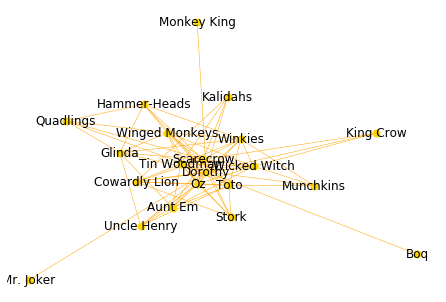

In [19]:
import json
import codecs
import networkx as nx
import matplotlib.pyplot as plt
nltk.download('punkt')

with codecs.open('/Users/mattmastin/Desktop/oz.json', 'r', 'utf-8-sig') as data:
    text = json.load(data)
    cast = text['cast']
    
    G = nx.Graph()
    G.name = "The Social Network of Oz"
    
    pairs = cooccurrence(text, cast)
    for pair, wgt in pairs.items():
        if wgt > 0:
            G.add_edge(pair[0], pair[1], weight=wgt)
            
    # make Dorothy the center
    D = nx.ego_graph(G, 'Dorothy')
    edges, weights = zip(*nx.get_edge_attributes(D, 'weight').items())
    
    # push nodes away that are less related to Dorothy
    pos = nx.spring_layout(D, k=0.5, iterations=40)
    nx.draw(D, pos, node_color='gold', node_size=50, edgelist=edges,
           width=0.5, edge_color='orange', with_labels=True, font_size=12)
    plt.show()

In [20]:
from nltk import sent_tokenize

def matrix(test, cast):
    mtx = []
    for first in cast:
        row = []
        for second in cast:
            count = 0
            for title, chapter in text['chapters'].items():
                for sent in sent_tokenize(chapter):
                    if first in sent and second in sent:
                        count += 1
            row.append(count)
        mtx.append(row)
    return mtx

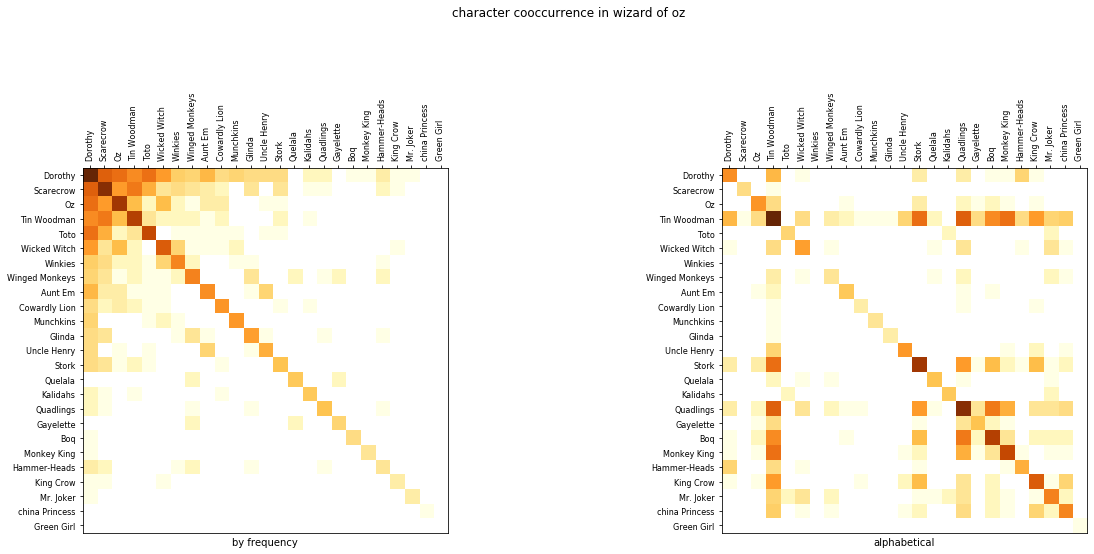

In [26]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

mtx = matrix(text, cast)

fig, ax = plt.subplots(figsize=(18,10))
fig.suptitle('character cooccurrence in wizard of oz', fontsize=12)
fig.subplots_adjust(wspace=.75)

n = len(cast)
x_tick_marks = np.arange(n)
y_tick_marks = np.arange(n)

ax1 = plt.subplot(121)
ax1.set_xticks(x_tick_marks)
ax1.set_yticks(y_tick_marks)
ax1.set_xticklabels(cast, fontsize=8, rotation=90)
ax1.set_yticklabels(cast, fontsize=8)
ax1.xaxis.tick_top()
ax1.set_xlabel('by frequency')
plt.imshow(mtx,
          norm=matplotlib.colors.LogNorm(),
          interpolation='nearest',
          cmap='YlOrBr')

alpha_cast = sorted(cast)
alpha_mtx = matrix(text, alpha_cast)

ax2 = plt.subplot(122)
ax2.set_xticks(x_tick_marks)
ax2.set_yticks(y_tick_marks)
ax2.set_xticklabels(cast, fontsize=8, rotation=90)
ax2.set_yticklabels(cast, fontsize=8)
ax2.xaxis.tick_top()
ax2.set_xlabel('alphabetical')
plt.imshow(alpha_mtx, 
          norm=matplotlib.colors.LogNorm(),
          interpolation='nearest',
          cmap='YlOrBr')
plt.show()

In [30]:
from nltk import word_tokenize, sent_tokenize

oz_words = []
headings = []
chap_lens = []
for heading, chapter in text['chapters'].items():
    # collect the chapter headings
    headings.append(heading)
    for sent in sent_tokenize(chapter):
        for word in word_tokenize(sent):
            # collect all words
            oz_words.append(word)
    # record the word lengths at each chapter
    chap_lens.append(len(oz_words))

#mark where chapters start    
chap_starts = [0] + chap_lens[:-1]
#combine with chapter headings
chap_marks = list(zip(chap_starts, headings))

cast.reverse()
points = []
# add a point for each time a character appears
for y in range(len(cast)):
    for x in range(len(oz_words)):
        #some chracaters have 1-word names
        if len(cast[y].split()) == 1:
            if cast[y] == oz_words[x]:
                points.append((x, y))
        # some characters have 2 word names
        else:
            if cast[y] == ' '.join((oz_words[x-1], oz_words[x])):
                points.append((x, y))
if points:
    x, y = list(zip(*points))
else:
    x = y = ()

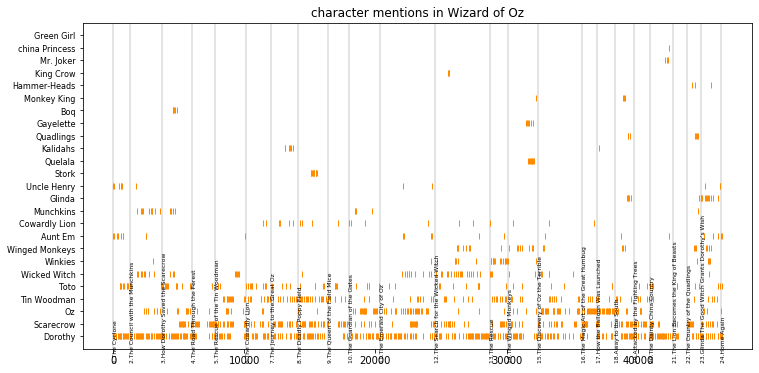

In [32]:
fig, ax = plt.subplots(figsize=(12, 6))
# verticle lines for each chapter start
for chap in chap_marks:
    plt.axvline(x=chap[0], linestyle='-',
               color='gainsboro')
    plt.text(chap[0], -2, chap[1], size=6, rotation=90)
# plotting character mentions
plt.plot(x, y, '|', color='darkorange', scalex=0.1)
plt.tick_params(
    axis='x', which='both', bottom='off', labelbottom='off')
plt.yticks(list(range(len(cast))), cast, size=8)
plt.ylim(-1, len(cast))
plt.title('character mentions in Wizard of Oz')
plt.show()

In [34]:
# conda install -c districtdatalabs yellowbrick 

Solving environment: | 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/osx-64::anaconda==2019.07=py37_0
  - defaults/osx-64::numba==0.44.1=py37h6440ff4_0
| 
  - anaconda::conda-4.7.11-py37_0
  - defaults::conda-4.7.11-py37done

## Package Plan ##

  environment location: //anaconda3

  added / updated specs:
    - yellowbrick


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _anaconda_depends-2019.03  |           py37_0           6 KB
    anaconda-custom            |           py37_1           3 KB
    ca-certificates-2019.5.15  |                1         126 KB
    certifi-2019.6.16          |           py37_1         152 KB
    openssl-1.1.1d             |       h1de35cc_0         2.2 MB
    pytest-runner-5.1          |             py_0          13 KB
    tbb-2019.4                 |       h04

In [40]:
# visual techniques for steering reature engineering, well-suited to text data
# Visual part-of-speech tagging and frequency distributions

# PosTagVisualizer not working properly

nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag, word_tokenize
from yellowbrick.text.postag import PosTagVisualizer

pie = """
        In a small saucepan, combine sugar and eggs
        until well blended. Cook over low heat, stirring
        constantly, until mixture reaches 160° and coats
        the back of a metal spoon. Remove from the heat.
        Stir in chocolate and vanilla until smooth. Cool
        to lukewarm (90°), stirring occasionally. In a small
        bowl, cream butter until light and fluffy. Add cooled
        chocolate mixture; beat on high speed for 5 minutes
        or until light and fluffy. In another large bowl,
        beat cream until it begins to thicken. Add
        confectioners' sugar; beat until stiff peaks form.
        Fold into chocolate mixture. Pour into crust. Chill
        for at least 6 hours before serving. Garnish with
        whipped cream and chocolate curls if desired.
        """

tokens = word_tokenize(pie)
tagged = pos_tag(tokens)

visualizer = PosTagVisualizer()
output = visualizer.transform(tagged)

print(' '.join((visualizer(token, color) for color, token in output)))
print('\n')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/mattmastin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


TypeError: 'PosTagVisualizer' object is not callable

In [41]:
import os
import yellowbrick as yb
from sklearn.datasets.base import Bunch

In [47]:
# FIXTURES = os.path.join(os.getcwd(), '/User/mattmastin/yellowbrick/examples/exbald')

from yellowbrick.datasets import load_hobbies

corpus = load_hobbies()

In [48]:
# corpora = {
#     'hobbies': os.path.join(FIXTURES, 'hobbies')
# }

# def load_corpus(name):
    
#     path = corpora[name]
    
#     categories = [
#         cat for cat in os.listdir(path)
#         if os.path.isdir(os.path.join(path, cat))
#     ]
    
#     files = []
#     data = []
#     target = []
    
#     for cat in categories:
#         for name in os.listdir(os.path.join(path, cat)):
#             files.append(os.path.join(path, cat, name))
#             target.append(cat)
            
#             with open(os.path.join(path, cat, name), 'r') as f:
#                 data.append(f.read())
                
#     return Bunch(categories=categories,
#                 files=files,
#                 data=data,
#                 target=target,)

# corpus = load_corpus('hobbies')

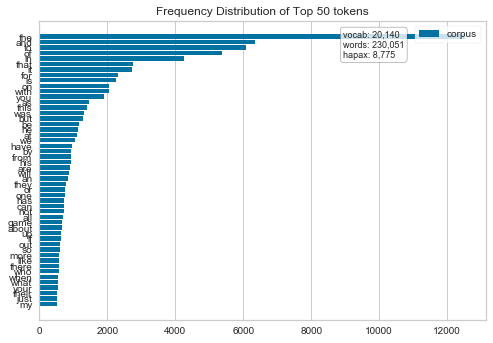

In [49]:
from yellowbrick.text.freqdist import FreqDistVisualizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
docs = vectorizer.fit_transform(corpus.data)
features = vectorizer.get_feature_names()

visualizer = FreqDistVisualizer(features=features)
visualizer.fit(docs)
visualizer.poof()

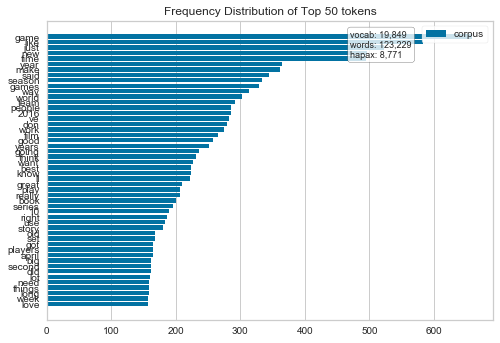

In [50]:
vectorizer = CountVectorizer(stop_words = 'english')
docs = vectorizer.fit_transform(corpus.data)
features = vectorizer.get_feature_names()

visualizer = FreqDistVisualizer(features=features)
visualizer.fit(docs)
visualizer.poof()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


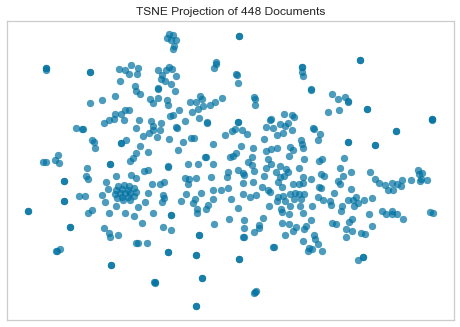

In [52]:
from yellowbrick.text import TSNEVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
docs = tfidf.fit_transform(corpus.data)

tsne = TSNEVisualizer()
tsne.fit(docs)
tsne.poof()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

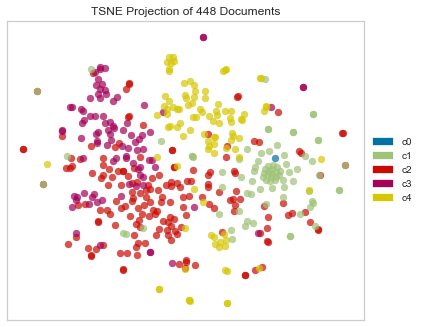

In [54]:
from sklearn.cluster import KMeans

clusters = KMeans(n_clusters=5)
clusters.fit(docs)

tsne = TSNEVisualizer()
tsne.fit(docs, ['c{}'.format(c) for c in clusters.labels_])
tsne.poof()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

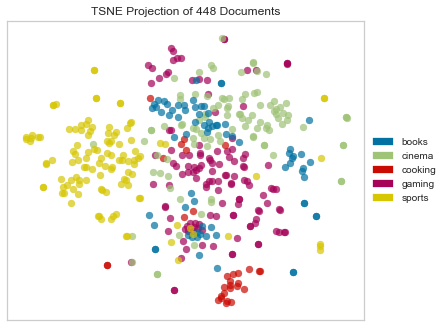

In [57]:
labels = corpus.target

tsne = TSNEVisualizer()
tsne.fit(docs, labels)
tsne.poof()

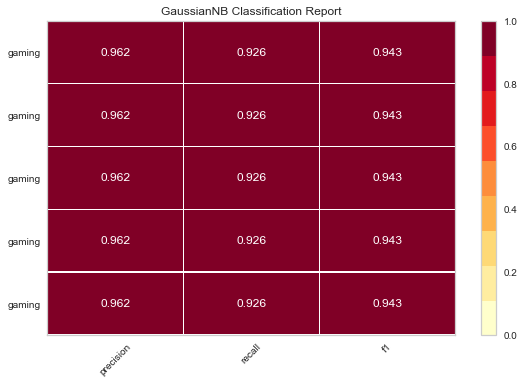

In [67]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ClassificationReport

docs = TfidfVectorizer().fit_transform(corpus.data)
labels = corpus.target

X_train, X_test, y_train, y_test = train_test_split(
    docs.toarray(), labels, test_size=0.2)

# corpus.categories has changed, corpus.target wrong
visualizer = ClassificationReport(GaussianNB(), classes=corpus.target)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

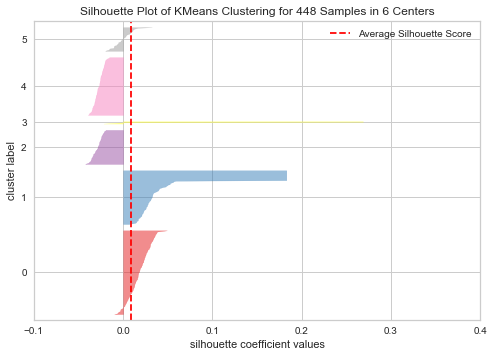

In [68]:
# Silhouette scores for 'cluster scoring'

from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer

visualizer = SilhouetteVisualizer(KMeans(n_clusters=6))
visualizer.fit(docs)
visualizer.poof()

//anaconda3/lib/python3.7/site-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
//anaconda3/lib/python3.7/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
//anaconda3/lib/python3.7/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


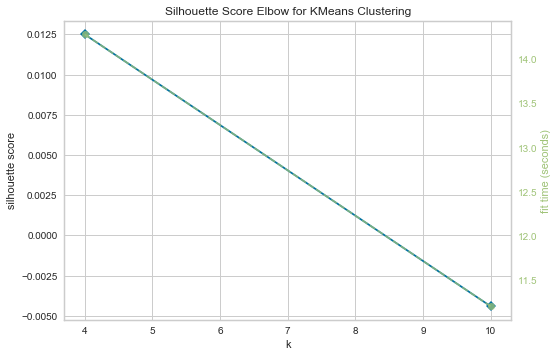

In [69]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(KMeans(), metric='silhouette', k=[4, 10])
visualizer.fit(docs)
visualizer.poof()

In [71]:
# graph analysis of text
# basically a thesaurus

import networkx as nx
from nltk.corpus import wordnet as wn
nltk.download('wordnet')

def graph_synsets(terms, pos=wn.NOUN, depth=2):
    """
    create a networkx graph of the given terms to given depth
    """
    
    G = nx.Graph(
        name='WordNet Synsets Graph for {}'.format(",".join(terms)), depth=depth,)
    
    def add_term_links(G, term, current_depth):
        for syn in wn.synsets(term):
            for name in syn.lemma_names():
                G.add_edge(term, name)
                if current_depth < depth:
                    add_term_links(G, name, current_depth+1)
                    
    for term in terms:
        add_term_links(G, term, 0)
        
    return G

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mattmastin/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [73]:
G = graph_synsets(['trinket'])
print(nx.info(G))

Name: WordNet Synsets Graph for trinket
Type: Graph
Number of nodes: 25
Number of edges: 49
Average degree:   3.9200


In [75]:
nx.diameter(G)

5

In [76]:
def draw_text_graph(G):
    pos = nx.spring_layout(G, scale=18)
    nx.draw_networkx_nodes(
        G, pos, node_color='white', linewidths=0, node_size=500)
    nx.draw_networkx_labels(G, pos, font_size=10)
    nx.draw_networkx_edges(G, pos, edge_color='lightgrey')
    
    plt.tick_params(axis='both',
                   which='both',
                   bottom='off',
                   left='off',
                   labelbottom='off',
                   labelleft='off')
    
    plt.show()

AttributeError: 'str' object has no attribute 'nodes'

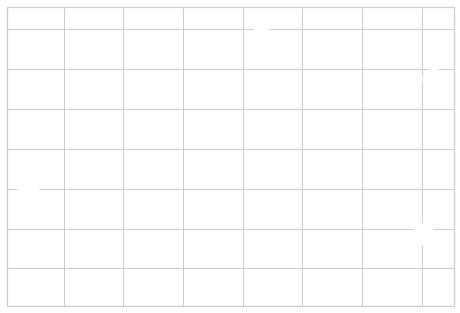

In [77]:
draw_text_graph('trinket')

In [78]:
# Building a 'social' network

import itertools
from sklearn.base import BaseEstimator, TransformerMixin
import networkx as nx

class EntityPairs(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        super(EntityPairs, self).__init__()
        
    def pairs(self, document):
        return list(itertools.permutations(set(document), 2))
    
    def fit(self, documents, labels=None):
        return self
    
    def transform(self, documents):
        return [self.pairs(document) for document in documents]
    
    
class GraphExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.G = nx.Graph()
        
    def fit(self, documents, labels=None):
        return self
    
    def transform(self, documents):
        for document in documents:
            for first, second in document:
                if (first, second) in self.G.edges():
                    self.G.edges[(first, second)]['weight'] += 1
                else:
                    self.G.add_edge(first, second, weight=1)
        return self.G
    
    
if __name__ == '__main__':
    from reader import PickledCorpusReader
    from sklearn.pipeline import Pipeline
    
    corpus = PickledCorpusReader('../corpus')
    docs = corpus.docs()
    
    graph = Pipeline([('entities', EntityExtractor()),
                     ('pairs', EntityPairs()),
                     ('graph', GraphExtractor())])
    
    G = graph.fit_transform(docs)
    print(nx.info(G))

ModuleNotFoundError: No module named 'reader'

In [ ]:
# uses arbitrary centrality measure to rank top n nodes and assigned each node
# a property with a score

import heapq
from operator import itemgetter

def nbest_centrality(G, metrics, n=10):
    #computer centrality scores for each vertex
    nbest = {}
    for name, metric in metrics.items():
        scores = metric(G)
        
        # set the score as a property on each node
        nx.set_node_attributes(G, name=name, values=scores)
        
        # find the top n scores and print them along with their index
        topn = heapq.nlargest(n, scores.items(), key=itemgetter(1))
        nbest[name] = topn
        
    return nbest

In [ ]:
from tabulate import tabulate
corpus = PickledCorpusReader('../corpus')
docs = corpus.docs()

graph = Pipeline([('entities', EntityExtractor()),
                 ('pairs', EntityPairs()),
                 ('graph', GraphExtractor())])

G = graph.fit_transform(docs)

centralities = {'Degree Centrality' : nx.degree_centrality,
               'Betweenness Centrality' : nx.betweenness_centrality}

centrality = nbest_centrality(G, centralities, 10)

for measure, scores in centrality.items():
    print('rankings for {}:'.format(measure))
    print((tabulate(scores, headers=['top terms', 'score'])))
    print('')

In [ ]:
# entity resolution

import networkx as nx
from itertools import combinations

def pairwise_comparisons(G):
    """
    produces a generator of pairs of ndoes
    """
    
    return combinations(G.nodes(), 2)

In [79]:
# chatbot

import abc

class Dialog(abc.ABC):
    """
    dialog listens for utterances, parses and interprets them, then updates
    internal state. Can then formulate a response on demand
    """
    
    def listen(self, text, response=True, **kwargs):
        """
        text utterance is passed and parsed. Then passed to interpret method
        to determine how to respond. If response requested, then respond method
        used to generate text response based on most recent input
        and current Dialog state
        """
        
        sents = self.parse(text)
        
        sents, confidence, kwargs = self.interpret(sents, **kwargs)
        
        if response:
            reply = self.respond(sents, confidence, **kwargs)
        else:
            reply = None
            
        return reply, confidence
    
    @abc.abstractmethod
    def parse(self, text):
        """
        every dialog may need own parsing strategy, some dialogs may need
        dependency vs constituency parses, others may simply require regular
        expressions or chunkers
        """
        
        return []
    
    @abc.abstractmethod
    def interpret(self, sents, **kwargs):
        """
        interprets utterance passed in as alist of parsed sentence,s
        updates internal state of dialog, computes confidence of interpretation,
        may also return arguments specific to response mechanism
        """
        return sents, 0.0, kwargs
    
    @abc.abstractmethod
    def respond(self, sents, confidence, **kwargs):
        """
        creates response given input utterances and current state of dialog,
        along with any arguments passed in from listen or interpret
        """
        return None

In [ ]:
from collections.abc import Sequence
from operator import itemgetter

class SimpleConversation(Dialog, Sequence):
    
    def __init__(self, dialogs):
        self._dialogs = dialogs
        
    def __getitem__(self, idx):
        return self._dialogs[idx]
    
    def __len__(self):
        return len(self._dialogs)
    
    def listen(self, text, response=True, **kwargs):
        """
        simply return the best confidence response
        """
        
        responses = [
            dialog.listen(text, response, **kwargs)
            for dialog in self._dialogs
        ]
        
        # responses is a list of (response, confidence) pairs
        return max(responses, key=itemgetter(1))
    
    def parse(self, text):
        """
        return parses for all internal dialogs for debugging
        """
        
        return [dialog.parse(text) for dialog in self._dialogs]
    
    def interpret(self, sents, **kwargs):
        """
        returns interpretations for all internal dialogs for debugging
        """
        
        return [dialog.interpret(sents, **kwargs) for dialog in self._dialogs]
    
    def respond(self, sents, confidence, **kwargs):
        """
        returns responses for all internal dialogs for debugging
        """
        
        return [
            dialog.respond(sents, confidence, **kwargs)
            for dialog in self._dialogs
        ]

In [82]:
class Greeting(Dialog):
    """
    keeps track of participants entering or leaving convo and responds
    with appropriate salutations. An example of a rules based system that 
    keeps track of state and uses regular expressions and logic to
    handle the dialog
    """
    
    PATTERNS = {
        'greeting': r'hello|hi|hey|good morning|good evening',
        'introduction': r'my name is ([a-z\-\s]+)',
        'goodbye': r'goodbye|bye|ttyl',
        'rollcall': r'roll call|who\'s here?',
    }
    
    def __init__(self, participants=None):
        #particpants is a map of user name to real name
        self.participants = {}
        
        if participants is not None:
            for participant in participants:
                self.participants[participant] = None
                
        # compile regular expressions
        self._patterns = {
            key: re.compile(pattern, re.I)
            for key, pattern in self.PATTERNS.items()
        }
        
    def parse(self, text):
        """
        applies all regular expressions to the text to find matches
        """
        
        matches = {}
        for key, pattern in self._patterns.items():
            match = pattern.match(text)
            if match is not None:
                matches[key] = match
        return matches
    
    def interpret(self, sents, **kwargs):
        """
        takes in parsed matches and determines if message is an enter,
        exit or name change
        """
        
        # can't do anything with no matches
        if len(sents) == 0:
            return sents, 0.0, kwargs
        
        # get username from participants
        user = kwargs.get('user', None)
        
        # determine if an introduction has been made
        if 'introduction' in sents:
            # get the name from the utterance
            name = sents['introduction'].groups()[0]
            user = user or name.lower()
            
            # determine if name has changed
            if user not in self.participants or self.participants[user] != name:
                kwargs['name_changed'] = True
                
            # update the participants
            self.participants[user] = name
            kwargs['user'] = user
            
        # determine if a greeting has been made
        if 'greeting' in sents:
            # if we don't have a name for the user
            if not self.participants.get(user, None):
                kwargs['request_introduction'] = True
                
        # determine if goodbye has been made
        if 'goodbye' in sents and user is not None:
            # remove participant
            self.participants.pop(user)
            kwargs.pop('user', None)
            
        # if we've seen anything we're looking for, we're pretty confident
        return sents, 1.0, kwargs
    
    def respond(self, sents, confidence, **kwargs):
        """
        gives a greeting or goodbye depending on what's approprite
        """
        
        if confidence == 0:
            return None
        
        name = self.participants.get(kwargs.get('user', None), None)
        name_changed = kwargs.get('name_changed', False)
        request_introduction = kwargs.get('request_introduction', False)
        
        if 'greeting' in sents or 'introduction' in sents:
            if request_introduction:
                return 'Hellow, what is your name?'
            else:
                return 'Hello, {}!'.format(name)
            
        if 'goodbye' in sents:
            return 'talk to you lata!'
        
        if 'rollcall' in sents:
            people = list(self.participants.values())
            
            if len(people) > 1:
                roster = ",".join(people[:-1])
                roster += ' and {}.'.format(people[-1])
                return 'currenty in the conversation are ' + roster
            
            elif len(people) == 1:
                return "it's just you and me right now, {}.".format(name)
            else:
                return "so lonely in here by myself ... wait who is that?"
            
        raise Exception(
            'expected response to be returned, but could not find rule')
        
    if __name__ == '__main__':
        dialog = Greeting()
        # listen returns (response, confidence) tuples; just print the response
#         print(dialog.listen('hello!', user=''))

In [ ]:
import pytest

class TestBaseClasses(object):
    """
    tests for the Dialog class
    """
    @pytest.mark.parametrize('text', [
        'Gobbledguk', 'Gibberish', 'Windings'
    ])
    def test_dialog_abc(self, text):
        """
        test the Dialog ABC and listen method
        """
        
        class SampleDialog(Dialog):
            def parse(self, text):
                return []
            
            def interpret(self, sents):
                return sents, 0.0, {}
            
            def respond(self, sents, confidence):
                return None
            
        sample = SampleDialog()
        reply, confidence = sample.isten(text)
        